# Train from data

This notebook walks you through training a normalizing flow by gradient descent when data is available.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.utils.data as data

import zuko

_ = torch.random.manual_seed(0)

## Dataset

We consider the *Two Moons* dataset for demonstrative purposes.

In [2]:
def two_moons(n: int, sigma: float = 1e-1):
    theta = 2 * torch.pi * torch.rand(n)
    label = (theta > torch.pi).float()

    x = torch.stack(
        (
            torch.cos(theta) + label - 1 / 2,
            torch.sin(theta) + label / 2 - 1 / 4,
        ),
        axis=-1,
    )

    return torch.normal(x, sigma), label


samples, labels = two_moons(1000)

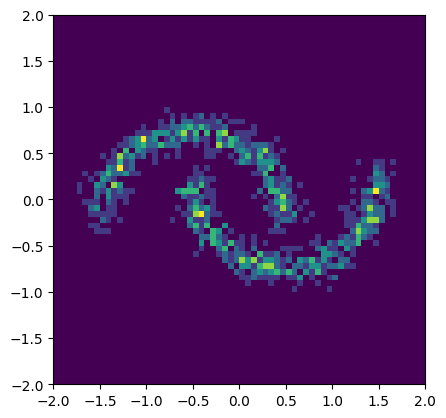

In [3]:
plt.figure(figsize=(4.8, 4.8))
plt.hist2d(*samples.T, bins=64, range=((-2, 2), (-2, 2)))
plt.show()

In [4]:
trainset = data.TensorDataset(*two_moons(1000))
trainloader = data.DataLoader(trainset, batch_size=64, shuffle=True)

test_x, test_label = two_moons(1000)

## Unconditional flow

We use a neural spline flow (NSF) as density estimator $q_\phi(x)$. The goal of the unconditional flow is to approximate the entire Two Moons distribution.

In [5]:
flow = zuko.flows.NSF(features=2, transforms=3, hidden_features=(64, 64))
flow

NSF(
  (transform): LazyComposedTransform(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=2, out_features=64, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=64, out_features=46, bias=True)
      )
    )
    (1): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [1, 0]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=2, out_features=64, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=64, out_features=46, bias=True)
      )
    )
    (2): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_featur

The objective is to minimize the Kullback-Leibler (KL) divergence between the true data distribution $p(x)$ and the modeled distribution $q_\phi(x)$.

$$
    \begin{align}
        \arg \min_\phi & ~ \mathrm{KL} \big( p(x) || q_\phi(x) \big) \\
        = \arg \min_\phi & ~ \mathbb{E}_{p(x)} \left[ \log \frac{p(x)}{q_\phi(x)} \right] \\
        = \arg \min_\phi & ~ \mathbb{E}_{p(x)} \big[ -\log q_\phi(x) \big]
    \end{align}
$$

In [6]:
optimizer = torch.optim.AdamW(flow.parameters(), lr=1e-3, weight_decay=1e-4)

for epoch in range(100):
    losses = []

    for x, label in trainloader:
        loss = -flow().log_prob(x).mean()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.detach())

    losses = torch.stack(losses)

    print(f"({epoch})", losses.mean().item(), "±", losses.std().item())

(0) 1.996619701385498 ± 0.250036358833313
(1) 1.6037672758102417 ± 0.11686454713344574
(2) 1.4650659561157227 ± 0.0453653410077095
(3) 1.387320876121521 ± 0.0824376791715622
(4) 1.3605194091796875 ± 0.07013952732086182
(5) 1.2789711952209473 ± 0.10443997383117676
(6) 1.237025260925293 ± 0.07448438555002213
(7) 1.2322725057601929 ± 0.09333717077970505
(8) 1.201568603515625 ± 0.08904331922531128
(9) 1.1874268054962158 ± 0.0843881368637085
(10) 1.2133920192718506 ± 0.08842655271291733
(11) 1.1968262195587158 ± 0.08462487161159515
(12) 1.181791067123413 ± 0.07120424509048462
(13) 1.1497459411621094 ± 0.08749637752771378
(14) 1.1255805492401123 ± 0.1050260066986084
(15) 1.1371259689331055 ± 0.07686102390289307
(16) 1.1566861867904663 ± 0.11161667108535767
(17) 1.1369202136993408 ± 0.08530694246292114
(18) 1.1376010179519653 ± 0.08180979639291763
(19) 1.126339077949524 ± 0.09828522801399231
(20) 1.1175992488861084 ± 0.08690910786390305
(21) 1.1267427206039429 ± 0.10645652562379837
(22) 1.088

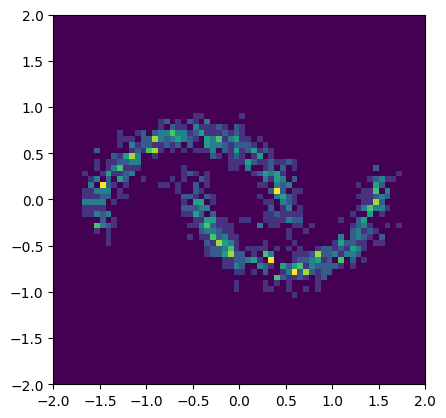

In [7]:
samples = flow().sample((1000,))

plt.figure(figsize=(4.8, 4.8))
plt.hist2d(*samples.T, bins=64, range=((-2, 2), (-2, 2)))
plt.show()

In [8]:
flow2 = zuko.flows.MAF(features=2, transforms=5, hidden_features=(64, 64))

optimizer = torch.optim.AdamW(flow2.parameters(), lr=1e-3, weight_decay=1e-4)

for epoch in range(100):
    losses = []

    for x, label in trainloader:
        loss = -flow2().log_prob(x).mean()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.detach())

    losses = torch.stack(losses)

    print(f"({epoch})", losses.mean().item(), "±", losses.std().item())

(0) 1.932283878326416 ± 0.14400248229503632
(1) 1.7642014026641846 ± 0.06338301301002502
(2) 1.7229665517807007 ± 0.08344265073537827
(3) 1.6897156238555908 ± 0.05950012430548668
(4) 1.672749400138855 ± 0.05270707234740257
(5) 1.6257339715957642 ± 0.06834281235933304
(6) 1.601474404335022 ± 0.05873863771557808
(7) 1.532543420791626 ± 0.06729421019554138
(8) 1.4735016822814941 ± 0.05300941690802574
(9) 1.4217138290405273 ± 0.06117694079875946
(10) 1.3586575984954834 ± 0.09479615837335587
(11) 1.376497507095337 ± 0.08925040066242218
(12) 1.3546442985534668 ± 0.09705409407615662
(13) 1.3252474069595337 ± 0.07240064442157745
(14) 1.412146806716919 ± 0.12748220562934875
(15) 1.3962186574935913 ± 0.09795406460762024
(16) 1.3164650201797485 ± 0.09691786020994186
(17) 1.2710835933685303 ± 0.09501996636390686
(18) 1.2493345737457275 ± 0.1039852648973465
(19) 1.2759050130844116 ± 0.09704627841711044
(20) 1.3203816413879395 ± 0.08726617693901062
(21) 1.2374529838562012 ± 0.09718557447195053
(22) 

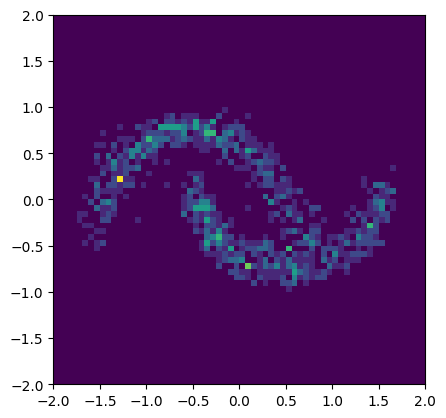

In [9]:
samples = flow2().sample((1000,))

plt.figure(figsize=(4.8, 4.8))
plt.hist2d(*samples.T, bins=64, range=((-2, 2), (-2, 2)))
plt.show()

In [10]:
flow3 = zuko.flows.NCSF(features=2, transforms=3)

optimizer = torch.optim.AdamW(flow3.parameters(), lr=1e-3, weight_decay=1e-4)

for epoch in range(100):
    losses = []

    for x, label in trainloader:
        loss = -flow3().log_prob(x).mean()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.detach())

    losses = torch.stack(losses)

    print(f"({epoch})", losses.mean().item(), "±", losses.std().item())

(0) 2.995678424835205 ± 0.36531224846839905
(1) 2.1830172538757324 ± 0.18108361959457397
(2) 1.7349634170532227 ± 0.11918029934167862
(3) 1.504035234451294 ± 0.08179254084825516
(4) 1.4363949298858643 ± 0.06374401599168777
(5) 1.3708398342132568 ± 0.09311435371637344
(6) 1.3357666730880737 ± 0.11019252985715866
(7) 1.3094160556793213 ± 0.10804176330566406
(8) 1.275383472442627 ± 0.13453154265880585
(9) 1.2744522094726562 ± 0.09611113369464874
(10) 1.2312860488891602 ± 0.07898404449224472
(11) 1.2798168659210205 ± 0.08337085694074631
(12) 1.2470402717590332 ± 0.10767621546983719
(13) 1.2278112173080444 ± 0.1057753935456276
(14) 1.2291581630706787 ± 0.11671019345521927
(15) 1.2029014825820923 ± 0.11637059599161148
(16) 1.2002851963043213 ± 0.06501365453004837
(17) 1.1970188617706299 ± 0.11908204853534698
(18) 1.211043119430542 ± 0.11500019580125809
(19) 1.1920514106750488 ± 0.07059995085000992
(20) 1.1884984970092773 ± 0.1047789677977562
(21) 1.1613900661468506 ± 0.10661423951387405
(22)

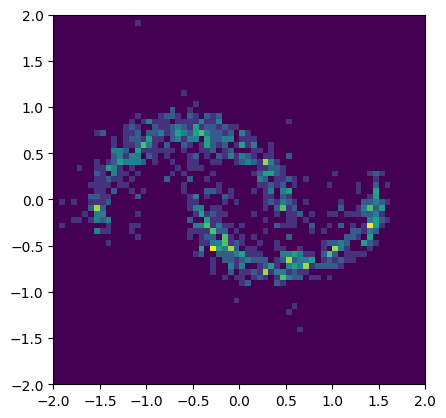

In [11]:
samples = flow3().sample((1000,))

plt.figure(figsize=(4.8, 4.8))
plt.hist2d(*samples.T, bins=64, range=((-2, 2), (-2, 2)))
plt.show()

In [12]:
flow4 = zuko.flows.BPF(features=2, degree=24)

optimizer = torch.optim.AdamW(flow4.parameters(), lr=1e-3, weight_decay=1e-4)

for epoch in range(100):
    losses = []

    for x, label in trainloader:
        loss = -flow4().log_prob(x).mean()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.detach())

    losses = torch.stack(losses)

    print(f"({epoch})", losses.mean().item(), "±", losses.std().item())

(0) 2.2231271266937256 ± 0.13135193288326263
(1) 1.9207918643951416 ± 0.07333925366401672
(2) 1.838468313217163 ± 0.07340836524963379
(3) 1.8065996170043945 ± 0.06702890247106552
(4) 1.7680912017822266 ± 0.039197999984025955
(5) 1.7214806079864502 ± 0.05531447008252144
(6) 1.6926734447479248 ± 0.07976297289133072
(7) 1.6591075658798218 ± 0.07147618383169174
(8) 1.6207255125045776 ± 0.06347820162773132
(9) 1.5679813623428345 ± 0.08531095087528229
(10) 1.5823065042495728 ± 0.13092508912086487
(11) 1.5211992263793945 ± 0.08367288112640381
(12) 1.4830880165100098 ± 0.08856957405805588
(13) 1.4789599180221558 ± 0.09312645345926285
(14) 1.4407329559326172 ± 0.08699232339859009
(15) 1.4362807273864746 ± 0.09823860973119736
(16) 1.4005122184753418 ± 0.06922607868909836
(17) 1.39169442653656 ± 0.09064814448356628
(18) 1.3818566799163818 ± 0.09780356287956238
(19) 1.3678486347198486 ± 0.06632281839847565
(20) 1.3633722066879272 ± 0.09200074523687363
(21) 1.3420813083648682 ± 0.07265512645244598


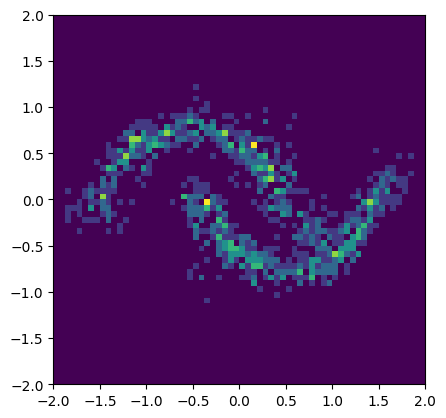

In [13]:
samples = flow4().sample((1000,))

plt.figure(figsize=(4.8, 4.8))
plt.hist2d(*samples.T, bins=64, range=((-2, 2), (-2, 2)))
plt.show()

In [14]:
from math import prod

count = 0
for param in flow.parameters():
    count += prod(list(param.shape))

print(count)

count = 0
for param in flow2.parameters():
    count += prod(list(param.shape))

print(count)

count = 0
for param in flow3.parameters():
    count += prod(list(param.shape))

print(count)

count = 0
for param in flow4.parameters():
    count += prod(list(param.shape))

print(count)

22026
23060
22026
22806


## Conditional flow

We use a conditional NSF as density estimator $q_\phi(x | c)$, where $c$ is the label indicating either the top or bottom moon of the Two Moons distribution.

In [78]:
cflow = zuko.flows.NSF(features=2, context=2, transforms=2, hidden_features=(32, 32))
cflow2 = zuko.flows.MAF(features=2, context=2, transforms=4, hidden_features=(32, 32))
cflow3 = zuko.flows.NCSF(features=2, context=2, transforms=2, hidden_features=(32, 32))
cflow4 = zuko.flows.BPF(features=2, context=2, degree=8, hidden_features=(32, 32))

from math import prod

count = 0
for param in cflow.parameters():
    count += prod(list(param.shape))

print(count)

count = 0
for param in cflow2.parameters():
    count += prod(list(param.shape))

print(count)

count = 0
for param in cflow3.parameters():
    count += prod(list(param.shape))

print(count)

count = 0
for param in cflow4.parameters():
    count += prod(list(param.shape))

print(count)


5468
5392
5468
5430


In [79]:
n = 128
trainset = data.TensorDataset(*two_moons(n))
trainloader = data.DataLoader(trainset, batch_size=n//2, shuffle=True)

for i, cf in enumerate([cflow, cflow2, cflow3, cflow4]):
    optimizer = torch.optim.AdamW(cf.parameters(), lr=1e-3, weight_decay=1e-4)

    for epoch in range(500):
        losses = []

        for x, label in trainloader:
            c = torch.nn.functional.one_hot(label.type(torch.long), 2).type(torch.float16)

            loss = -cf(c).log_prob(x).mean()
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            losses.append(loss.detach())

        losses = torch.stack(losses)

    print(f"cflow({i})", losses.mean().item(), "±", losses.std().item())

cflow(0) 0.0014458401128649712 ± 0.03472345322370529
cflow(1) 0.07626909017562866 ± 0.03098210133612156
cflow(2) -0.06487967073917389 ± 0.08099730312824249
cflow(3) 0.26029086112976074 ± 0.03773118555545807


NSF ACC: tensor(0.9930)
MAF ACC: tensor(0.9940)
NCSF ACC: tensor(0.9300)
BPF ACC: tensor(0.9960)


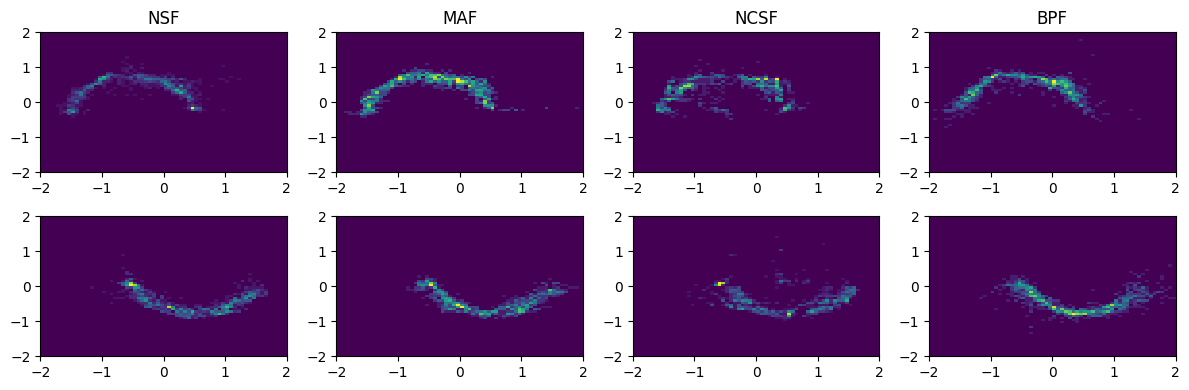

In [80]:
# sample from the flow conditioned on the top moon label
fig, axes = plt.subplots(2, 4, figsize=(12, 4))

c1 = torch.nn.functional.one_hot(torch.tensor(0.0).type(torch.long), 2).type(torch.float16)
c2 = torch.nn.functional.one_hot(torch.tensor(1.0).type(torch.long), 2).type(torch.float16)

for i, name, cf in zip(range(4), ['NSF', 'MAF', 'NCSF', 'BPF'], [cflow, cflow2, cflow3, cflow4]):
    samples1 = cf(c1).sample((1000,))
    samples2 = cf(c2).sample((1000,))

    log_probs = torch.stack(
        [
            cf(torch.broadcast_to(c1, test_x.shape[:1] + c1.shape)).log_prob(test_x),
            cf(torch.broadcast_to(c2, test_x.shape[:1] + c2.shape)).log_prob(test_x)
        ],
        -1)

    print(name, 'ACC:', torch.mean( (log_probs.argmax(-1) == test_label).type(torch.float) ))

    axes[0, i].hist2d(*samples1.T, bins=64, range=((-2, 2), (-2, 2)))
    axes[1, i].hist2d(*samples2.T, bins=64, range=((-2, 2), (-2, 2)))
    axes[0, i].set_title(name)

fig.tight_layout()

## Mixture of normalizing flows

The objective is to minimize the evidence lower bound (ELBO) of the following generative model:
$$ p(x|c) p(c) $$

We will test two cases:
- One where we directly minimize the marginal log-likelihood defined as  

$$ - \ln q_\phi(x) = - \ln [\sum_c q_\phi(x|c) p(c)]$$

and another where we used ammortized posterior $q_\rho(c|x)$ and minimize the 
corresponding ELBO 

$$
    \arg \min_{\phi, \rho} ~ \mathrm{KL} \big( q_\rho(c|x) || q_\phi(x|c) p(c) \big)
$$

In [117]:
from torchvision.ops import MLP

class ELBO(torch.nn.Module):
    def __init__(
        self,
        decoder: zuko.lazy.LazyDistribution,
        prior: zuko.lazy.LazyDistribution,
    ):
        super().__init__()

        self.decoder = decoder
        self.prior = prior

    def log_joint(self, x: torch.Tensor) -> torch.Tensor:
        n_components = self.prior._num_events
        log_probs = []
        one_hots = torch.nn.functional.one_hot(torch.arange(n_components), n_components).type(torch.float16).to(device=x.device)
        for c in one_hots:
            _c = torch.broadcast_to(c, x.shape[:1] + c.shape)
            log_probs.append(self.decoder(_c).log_prob(x))

        return torch.stack(log_probs, dim=-1) + self.prior.logits

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return - torch.logsumexp(self.log_joint(x), -1)
    
    def posterior(self, x: torch.Tensor) -> torch.Tensor:
        return torch.nn.Softmax(dim=-1)(self.log_joint(x))

    
class ELBOAmort(torch.nn.Module):
    def __init__(
        self,
        encoder: MLP,
        decoder: zuko.lazy.LazyDistribution,
        prior: zuko.lazy.LazyDistribution,
    ):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.prior = prior

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ln_q = self.encoder(x)
        n_components = ln_q.shape[-1]
        log_probs = []
        one_hots = torch.nn.functional.one_hot(torch.arange(n_components), n_components).type(torch.float16).to(device=x.device)
        for c in one_hots:
            _c = torch.broadcast_to(c, x.shape[:1] + c.shape)
            log_probs.append(self.decoder(_c).log_prob(x))
        
        q = torch.nn.Softmax(dim=-1)(ln_q)
        log_q_m_log_p = - torch.stack(log_probs, -1) - self.prior.logits + ln_q - torch.logsumexp(ln_q, dim=-1, keepdim=True)
        return torch.sum(log_q_m_log_p * q, -1)
    
cuda0 = torch.device('cuda:0')

NSF 1.0226130485534668 ± 0.04830825328826904
NSF classification ACC: tensor(0.8600)
MAF 1.0471971035003662 ± 0.015333621762692928
MAF classification ACC: tensor(1.)


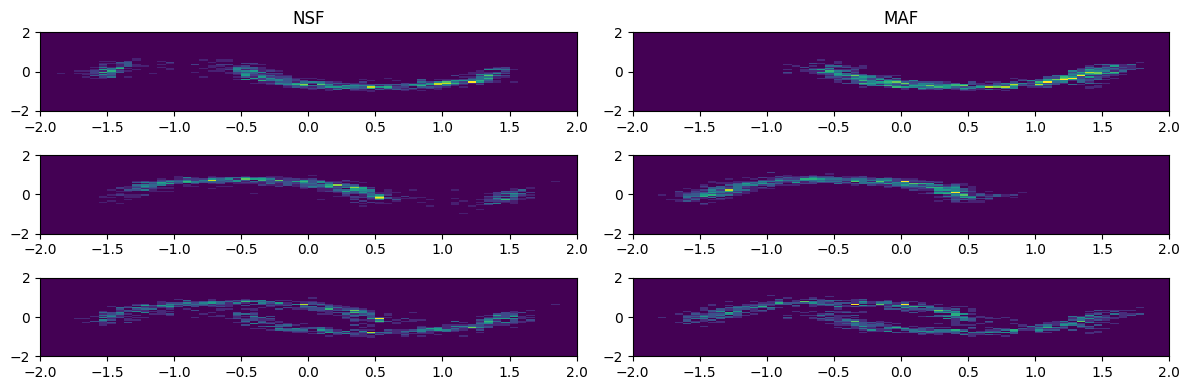

In [114]:
n = 2048
trainset = data.TensorDataset(*two_moons(n))
trainloader = data.DataLoader(trainset, batch_size=512, shuffle=True)

names = ['NSF', 'MAF']
fig, axes = plt.subplots(3, len(names), figsize=(12, 4))

cflow = zuko.flows.NSF(features=2, context=2, transforms=2, hidden_features=(32, 32))
cflow2 = zuko.flows.MAF(features=2, context=2, transforms=4, hidden_features=(32, 32))
cflow3 = zuko.flows.NCSF(features=2, context=2, transforms=2, hidden_features=(32, 32))
cflow4 = zuko.flows.BPF(features=2, context=2, degree=8, hidden_features=(32, 32))

decoders = [cflow, cflow2]
c1 = torch.nn.functional.one_hot(torch.tensor(0), 2).type(torch.float16).to(cuda0)
c2 = torch.nn.functional.one_hot(torch.tensor(1), 2).type(torch.float16).to(cuda0)

for i, name, decoder in zip(range(len(names)), names, decoders):
    cat = zuko.distributions.Categorical(logits=torch.zeros(2).to(cuda0))
    elbo = ELBO(decoder, cat).to(device=cuda0)
    optimizer = torch.optim.AdamW(elbo.parameters(), lr=1e-3, weight_decay=1e-4)
    all_losses = []
    for epoch in range(500):
        losses = []

        for x, label in trainloader:
            loss = elbo(x.to(device=cuda0)).mean()
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            losses.append(loss.detach())

        losses = torch.stack(losses)
        all_losses.append(losses.mean().item())
    print(f"{name}", losses.mean().item(), "±", losses.std().item())
    
    with torch.no_grad():
        samples1 = elbo.decoder(c1).sample((1000,))
        samples2 = elbo.decoder(c2).sample((1000,))
        cats = elbo.prior.sample((1000,)).to(cuda0)

        samples = torch.where((cats == 1).unsqueeze(dim=-1), samples2, samples1)
        q = elbo.posterior(test_x.to(cuda0))

        acc = torch.mean((q.argmax(-1).cpu() == test_label).type(torch.float))
        print(f"{name} classification ACC:", torch.max(acc, 1 - acc))  # we do not know which component is which label, so just print larger value.



    axes[0, i].hist2d(*samples1.cpu().T, bins=64, range=((-2, 2), (-2, 2)))
    axes[1, i].hist2d(*samples2.cpu().T, bins=64, range=((-2, 2), (-2, 2)))
    axes[2, i].hist2d(*samples.cpu().T, bins=64, range=((-2, 2), (-2, 2)))
    axes[0, i].set_title(name)

fig.tight_layout()
    

### Variant with amortized categorical posterior

NSF 1.0095137357711792 ± 0.018883025273680687
NSF classification ACC: tensor(0.5810)
MAF 1.041966438293457 ± 0.03666805475950241
MAF classification ACC: tensor(0.9960)


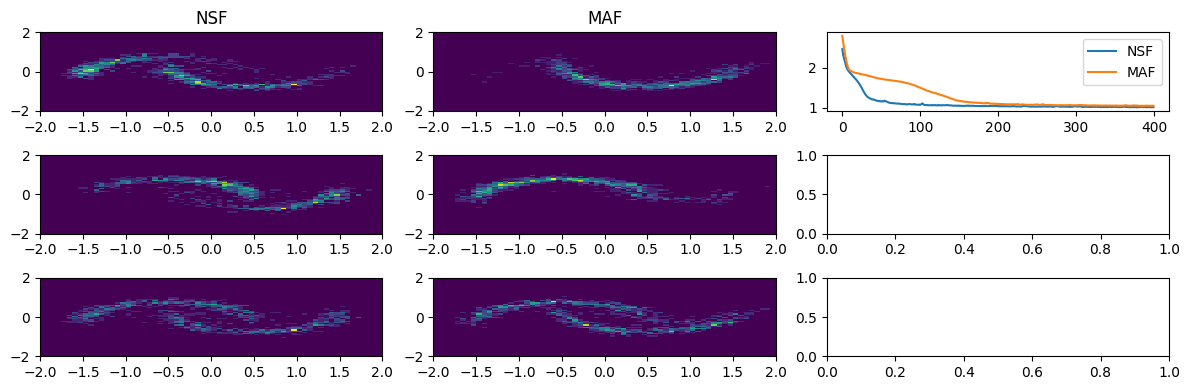

In [130]:
n_components = 2
n = 2048
trainset = data.TensorDataset(*two_moons(n))
trainloader = data.DataLoader(trainset, batch_size=512, shuffle=True)

names = ['NSF', 'MAF']
fig, axes = plt.subplots(3, len(names) + 1, figsize=(12, 4))

cflow = zuko.flows.NSF(features=2, context=2, transforms=2, hidden_features=(32, 32))
cflow2 = zuko.flows.MAF(features=2, context=2, transforms=4, hidden_features=(32, 32))
cflow3 = zuko.flows.NCSF(features=2, context=2, transforms=2, hidden_features=(32, 32))
cflow4 = zuko.flows.BPF(features=2, context=2, degree=8, hidden_features=(32, 32))

decoders = [cflow, cflow2]

c1 = torch.nn.functional.one_hot(torch.tensor(0), 2).type(torch.float16).to(cuda0)
c2 = torch.nn.functional.one_hot(torch.tensor(1), 2).type(torch.float16).to(cuda0)

for i, name, decoder in zip(range(len(names)), names, decoders):
    cat_net = MLP(in_channels=2, hidden_channels=[32, 32, n_components]).to(cuda0)
    cat = zuko.distributions.Categorical(logits=torch.zeros(n_components).to(cuda0))
    elbo = ELBOAmort(cat_net, decoder.to(cuda0), cat).to(cuda0)
    optimizer = torch.optim.AdamW(elbo.parameters(), lr=1e-3, weight_decay=1e-5)
    
    all_losses = []
    for epoch in range(400):
        losses = []

        for x, label in trainloader:
            loss = elbo(x.to(cuda0)).mean()
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            losses.append(loss.detach())

        losses = torch.stack(losses)
        all_losses.append(losses.mean().item())
    print(f"{name}", losses.mean().item(), "±", losses.std().item())

    with torch.no_grad():
        samples1 = elbo.decoder(c1).sample((1000,))
        samples2 = elbo.decoder(c2).sample((1000,))
        cats = elbo.prior.sample((1000,)).to(cuda0)

        samples = torch.where((cats == 1).unsqueeze(dim=-1), samples2, samples1)
        ln_q = elbo.encoder(test_x.to(cuda0))

        acc = torch.mean((ln_q.argmax(-1).cpu() == test_label).type(torch.float))
        print(f"{name} classification ACC:", torch.max(acc, 1 - acc))

    axes[0, i].hist2d(*samples1.cpu().T, bins=64, range=((-2, 2), (-2, 2)))
    axes[1, i].hist2d(*samples2.cpu().T, bins=64, range=((-2, 2), (-2, 2)))
    axes[2, i].hist2d(*samples.cpu().T, bins=64, range=((-2, 2), (-2, 2)))
    axes[0, i].set_title(name)

    axes[0, -1].plot(all_losses, label=name)

axes[0, -1].legend()
fig.tight_layout()